# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt                        
%matplotlib inline                 

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


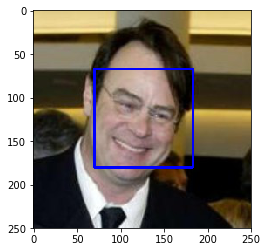

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

The percentage of the first 100 images in human_files that have a detected human face is 98%.

The percentage of the first 100 images in dog_files that have a detected human face is 17%.

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_num_face_detector=0
dog_num_face_detector=0
for kkk in range(0,len(human_files_short)):
    if face_detector(human_files_short[kkk])==True:
        human_num_face_detector=human_num_face_detector+1
    if face_detector(dog_files_short[kkk])==True:
        dog_num_face_detector=dog_num_face_detector+1
        
print(" percentage of the first 100 images in human_files have a detected human face:",human_num_face_detector," %")
print(" percentage of the first 100 images in dog_files have a detected human face:",dog_num_face_detector," %")

 percentage of the first 100 images in human_files have a detected human face: 98  %
 percentage of the first 100 images in dog_files have a detected human face: 17  %


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [9]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    transform = transforms.Compose([     # defining a variable transform which is a combination of all the image transformations to be carried out on the input image     
            transforms.Resize(256),      # Resize the image to 256×256 pixels     
            transforms.CenterCrop(224),  # Crop the image to 224×224 pixels about the center   
            transforms.ToTensor(),       # Convert the image to PyTorch Tensor data type  
            transforms.Normalize(        # Normalize the image by setting its mean and standard deviation to the specified values          
            mean=[0.485, 0.456, 0.406],        
            std=[0.229, 0.224, 0.225])])

    img = Image.open(img_path)
    img_t = transform(img) # shape: (3,224,224)
    batch_t = torch.unsqueeze(img_t, 0) # shape: (1,3,224,224)

    # put the model in eval mode
    VGG16.eval() 
    batch_t = batch_t.cuda()
    out = VGG16(batch_t) # shape: (1,1000)
    
    return torch.argmax(out, dim=1).item() # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    ## TODO: Complete the function.
    prediction = VGG16_predict(img_path)
    return ((prediction <= 268) & (prediction >= 151)) # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

The percentage of the first 100 images in human_files_short that have a detected dog is 0%.

The percentage of the first 100 images in dog_files_short that have a detected dog is 100%.

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_num_dog_detector=0
dog_num_dog_detector=0
for kkk in range(0,len(human_files_short)):
    if dog_detector(human_files_short[kkk])==True:
        human_num_dog_detector=human_num_dog_detector+1
    if dog_detector(dog_files_short[kkk])==True:
        dog_num_dog_detector=dog_num_dog_detector+1
        
print(" percentage of the first 100 images in human_files have a detected dog:",human_num_dog_detector,"%")
print(" percentage of the first 100 images in dog_files have a detected dog:",dog_num_dog_detector,"%")

 percentage of the first 100 images in human_files have a detected dog: 0 %
 percentage of the first 100 images in dog_files have a detected dog: 100 %


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [12]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_data_path = "/data/dog_images/train"
valid_data_path = "/data/dog_images/valid"
test_data_path = "/data/dog_images/test"

transform_img = transforms.Compose([          
            transforms.Resize(256),     # Resize the image to 256×256 pixels
            transforms.CenterCrop(224), # Crop the image to 224×224 pixels about the center       
            transforms.ToTensor(),      # Convert the image to PyTorch Tensor data type        
            transforms.Normalize(       # Normalize the image by setting its mean and standard deviation to the specified values           
            mean=[0.485, 0.456, 0.406],        
            std=[0.229, 0.224, 0.225])])

transform_label = transforms.Compose([transforms.ToTensor()])

BATCH_SIZE = 64

train_data = datasets.ImageFolder(root=train_data_path, transform=transform_img)
train_data.samples = [(d, torch.tensor(s)) for d, s in train_data.samples]
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)

valid_data = datasets.ImageFolder(root=valid_data_path, transform=transform_img)
valid_data.samples = [(d, torch.tensor(s)) for d, s in valid_data.samples]
valid_data_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)

test_data = datasets.ImageFolder(root=test_data_path, transform=transform_img)
test_data.samples = [(d, torch.tensor(s)) for d, s in test_data.samples]
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)

loaders_scratch = {}
loaders_scratch['train'] = train_data_loader
loaders_scratch['valid'] = valid_data_loader
loaders_scratch['test'] = test_data_loader

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

Initially, I resized the input image to 256 by 256 and then I did center cropping to a size of 224 by 224. The reason I chose 224 by 224 as the input image size is that a squared shape would be better for sequential CNN operations and it is required to have such input tensor size for the pre-trained models like ResNet50, VGG16, etc.

I did not augment the dataset, because the size of the training set, i.e. 6680 images, should be sufficient. Of course, augmenting the training set can lead to better performance.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [13]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(num_features=16)
            
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(num_features=128)
        
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(num_features=256)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.drop = nn.Dropout(0.5)
                
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, len(train_data.classes))


    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.maxpool(x)
        
        x = F.adaptive_avg_pool2d(x, (1, 1))  
        x = x.view(x.shape[:2]) 
        
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

#######
for name, param in model_scratch.named_parameters():
    if param.requires_grad:
        print('{}\t  Output shape: {}\t Parameters: {}\t'.format(
                name,
                param.size(),
                np.prod(param.size())
        ))
        
        
print()
model_parameters = filter(lambda p: p.requires_grad, model_scratch.parameters())
trainable_params = sum([np.prod(p.size()) for p in model_parameters])
print('trainable parameters: ', trainable_params)

total_params = sum([np.prod(p.size()) for p in model_scratch.parameters()])
print('total number of parameters:', total_params)
########

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

conv1.weight	  Output shape: torch.Size([16, 3, 5, 5])	 Parameters: 1200	
conv1.bias	  Output shape: torch.Size([16])	 Parameters: 16	
bn1.weight	  Output shape: torch.Size([16])	 Parameters: 16	
bn1.bias	  Output shape: torch.Size([16])	 Parameters: 16	
conv2.weight	  Output shape: torch.Size([32, 16, 5, 5])	 Parameters: 12800	
conv2.bias	  Output shape: torch.Size([32])	 Parameters: 32	
bn2.weight	  Output shape: torch.Size([32])	 Parameters: 32	
bn2.bias	  Output shape: torch.Size([32])	 Parameters: 32	
conv3.weight	  Output shape: torch.Size([64, 32, 3, 3])	 Parameters: 18432	
conv3.bias	  Output shape: torch.Size([64])	 Parameters: 64	
bn3.weight	  Output shape: torch.Size([64])	 Parameters: 64	
bn3.bias	  Output shape: torch.Size([64])	 Parameters: 64	
conv4.weight	  Output shape: torch.Size([128, 64, 3, 3])	 Parameters: 73728	
conv4.bias	  Output shape: torch.Size([128])	 Parameters: 128	
bn4.weight	  Output shape: torch.Size([128])	 Parameters: 128	
bn4.bias	  Output shape: tor

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

My proposed CNN architecture from scratch consists of 5 Conv2D layers, with each one of them being followed by a BatchNorm2d layer, a ReLU activation function and a MaxPooling2D layer. The filter size is 5 by 5 for the first 2 layers and 3 by 3 for the last 3 since the image size (height, width) decreases and we also want to extract higher level features. On the other hand, the number of filters increases, as we go deeper in the network. I added a batch normalization layer after each convolutional layer to allow each convolutional layer to learn by itself a bit more independently of other layers and thus speeding up the learning of the whole network. The MaxPooling2D layers were used for multiscale feature extraction. After, I used a global average pooling operation, which is applied for each channel independently, to get the average of the features for each channel and gives as outputs 1D tensors. I then add a fully connected layer with ReLU activation function followed by a dropout with dropout probability 50% to prevent overfitting and then a final fully connected layer, where the number of neurons is equal to the number of dog breeds. This final layer will provide the probability scores that an image belongs to each of the 133 breeds. I did not add a softmax activation function and the output of the layer is a logit since the loss function (i.e. CrossEntropyLoss()) in Pytorch takes care of that.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [14]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
lr = 1e-3
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

Epoch: 1 	Training Loss: 4.566309 	Validation Loss: 4.338493
Validation loss decreased from (inf ---> 4.338493).	
Epoch: 2 	Training Loss: 4.196584 	Validation Loss: 4.302642
Validation loss decreased from (4.338493 ---> 4.302642).	
Epoch: 3 	Training Loss: 4.023788 	Validation Loss: 4.148757
Validation loss decreased from (4.302642 ---> 4.148757).	
Epoch: 4 	Training Loss: 3.890668 	Validation Loss: 3.950556
Validation loss decreased from (4.148757 ---> 3.950556).	
Epoch: 5 	Training Loss: 3.756844 	Validation Loss: 3.710355
Validation loss decreased from (3.950556 ---> 3.710355).	
Epoch: 6 	Training Loss: 3.633340 	Validation Loss: 3.781016
Epoch: 7 	Training Loss: 3.498462 	Validation Loss: 3.697580
Validation loss decreased from (3.710355 ---> 3.697580).	
Epoch: 8 	Training Loss: 3.377542 	Validation Loss: 3.523666
Validation loss decreased from (3.697580 ---> 3.523666).	
Epoch: 9 	Training Loss: 3.232482 	Validation Loss: 3.560908
Epoch: 10 	Training Loss: 3.116971 	Validation Los

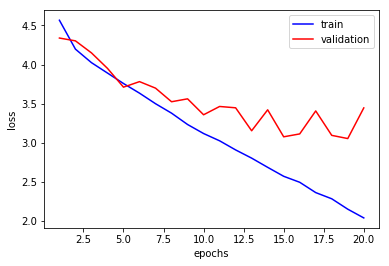

In [15]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    train_loss_vec = []
    valid_loss_vec = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear all optimized variables
            optimizer.zero_grad()
            # calculate the model output
            outputs = model(data)
            
            # calculate the training loss
            loss = criterion(outputs, target)
            # perform backward propagation
            loss.backward()
            # update the parameters
            optimizer.step()
            # update running training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            
        train_loss_vec.append(train_loss)
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                    
                ## update the average validation loss
                # calculate the model output
                outputs = model(data)
                # calculate the validation loss
                loss = criterion(outputs, target)
                # update running validation loss
                valid_loss += ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
                
            valid_loss_vec.append(valid_loss)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print("Validation loss decreased from ({:.6f} ---> {:.6f}).\t".format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
            
    fig = plt.figure()
    plt.plot(range(1, n_epochs+1),train_loss_vec, 'b', label='train')
    plt.plot(range(1, n_epochs+1), valid_loss_vec, 'r', label='validation')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
            
    # return trained model
    return model


# train the model
n_epochs = 20
model_scratch = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.854458


Test Accuracy: 28% (238/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [17]:
## TODO: Specify data loaders

loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [18]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)
# Freeze model weights
for param in model_transfer.parameters():
    param.requires_grad = False
    

In [19]:
model_transfer.fc = torch.nn.Linear(model_transfer.fc.in_features, len(train_data.classes))

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I used ResNet50 as the model architecture for transfer learning. I froze all layers apart from the last fully connected one where I changed the number of output neurons, which give the probability of the class, from 1000 neurons (since ResNet50 is trained on the ImageNet dataset where the images belong to 1000 classes) to 133 so we fit our needs. 

ResNet50 is trained on more than 14 million images which belong to 1000 different classes. This means that the first layers i.e. convolutional layers, are trained to extract features from different types of images. Our dog dataset consists of a much smaller number of images, i.e. 6680 images belonging to 133 distinct classes, and thus is more specific we need to fine-tune the final layer by changing the number of output neurons (i.e. 1000) to be equal to the number of dog breeds. This is the core idea of transfer learning.

I repeated the procedure by applying trannsfer learning using the VGG16 architecture, and the results were almost the same. The test accuracy when appying transfer learning using the ResNet50 was 87%, while when using the VGG16 architecture was 86%.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [20]:
criterion_transfer = nn.CrossEntropyLoss()
lr = 1e-3
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

Epoch: 1 	Training Loss: 2.180664 	Validation Loss: 0.972136
Validation loss decreased from (inf ---> 0.972136).	
Epoch: 2 	Training Loss: 0.650758 	Validation Loss: 0.611132
Validation loss decreased from (0.972136 ---> 0.611132).	
Epoch: 3 	Training Loss: 0.426277 	Validation Loss: 0.569083
Validation loss decreased from (0.611132 ---> 0.569083).	
Epoch: 4 	Training Loss: 0.328894 	Validation Loss: 0.498688
Validation loss decreased from (0.569083 ---> 0.498688).	
Epoch: 5 	Training Loss: 0.272658 	Validation Loss: 0.458099
Validation loss decreased from (0.498688 ---> 0.458099).	
Epoch: 6 	Training Loss: 0.218325 	Validation Loss: 0.446554
Validation loss decreased from (0.458099 ---> 0.446554).	
Epoch: 7 	Training Loss: 0.180561 	Validation Loss: 0.441095
Validation loss decreased from (0.446554 ---> 0.441095).	
Epoch: 8 	Training Loss: 0.154632 	Validation Loss: 0.425712
Validation loss decreased from (0.441095 ---> 0.425712).	
Epoch: 9 	Training Loss: 0.137612 	Validation Loss: 0

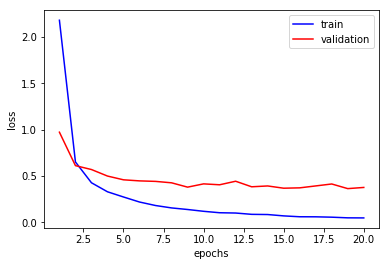

In [21]:
# train the model
n_epochs = 20
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [22]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.479856


Test Accuracy: 87% (732/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [23]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    img_t = transform_img(img) # shape: (3,224,224)
    batch_t = torch.unsqueeze(img_t, 0) # shape: (1,3,224,224)
    batch_t = batch_t.cuda()
    
    model_transfer.eval()
    out = model_transfer(batch_t) # shape: (1,133)
    index = torch.argmax(out, dim=1).item()
    
    
    return class_names[index]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [24]:
def model_predict(model, img_path):
    '''
    Use pre-trained model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to  model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    transform = transforms.Compose([     # defining a variable transform which is a combination of all the image transformations to be carried out on the input image     
            transforms.Resize(256),      # Resize the image to 256×256 pixels     
            transforms.CenterCrop(224),  # Crop the image to 224×224 pixels about the center   
            transforms.ToTensor(),       # Convert the image to PyTorch Tensor data type  
            transforms.Normalize(        # Normalize the image by setting its mean and standard deviation to the specified values          
            mean=[0.485, 0.456, 0.406],        
            std=[0.229, 0.224, 0.225])])

    img = Image.open(img_path)
    img_t = transform(img) # shape: (3,224,224)
    batch_t = torch.unsqueeze(img_t, 0) # shape: (1,3,224,224)
    #batch_t = batch_t.cuda()
    # put the model in eval mode
    model.eval() 
    out = model(batch_t) # shape: (1,1000)
    
    return torch.argmax(out, dim=1).item() # predicted class index

In [25]:
def dog_detector_model(model, img_path):
    ## TODO: Complete the function.
    ## TODO: Complete the function.
    prediction = model_predict(model, img_path)
    return ((prediction <= 268) & (prediction >= 151)) # true/false

In [26]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

ResNet50 = models.resnet50(pretrained=True)

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    img = cv2.imread(img_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()
        
    if dog_detector_model(ResNet50, img_path)==True:        
        print('hello dog!')
        print('Your breed is ...')
        print(predict_breed_transfer(img_path))      
    elif face_detector(img_path)==True:
        print('hello human!')
        print('Your look like a ...')
        print(predict_breed_transfer(img_path))        
    else:
        print('picture has neither dog nor human')

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

Answer:

The dog breed classifier algorithm gives good results on the additional images that I provided. Out of the 6 dog images I provided, it correctly classified 5 of them. It also gave an error when i gave a cat and a rabbit image as input. These conclusions hold true for both cases of transfer learning I applied, i.e. using as base models the ResNet50 and VGG16 architectures and weights.   

So, it is better than I expected. 

Possible points of improvement:

- Use a different and better architecture as base model for transfer learning.  
- Train for higher number of epochs and deal with learning rate in a more sophisticated way in order to get better prediction accuracy
- Perform data augmentation to increase the size of the training set




In [27]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
# for file in np.hstack((human_files[:3], dog_files[:3])):
#     run_app(file)

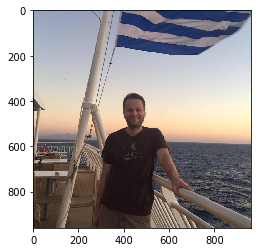

hello human!
Your look like a ...
Icelandic sheepdog


In [28]:
img_path='./images/myself.jpg'
run_app(img_path)

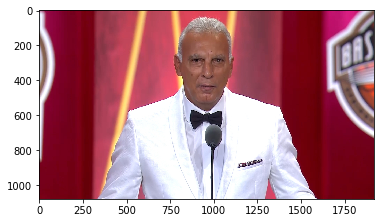

hello human!
Your look like a ...
Poodle


In [29]:
img_path='./images/Galis.jpg'
run_app(img_path)

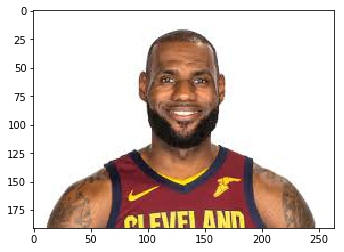

hello human!
Your look like a ...
Doberman pinscher


In [30]:
img_path='./images/Lebron.jpg'
run_app(img_path)

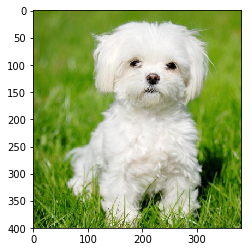

hello dog!
Your breed is ...
Maltese


In [31]:
img_path='./images/Maltese.jpg'
run_app(img_path)

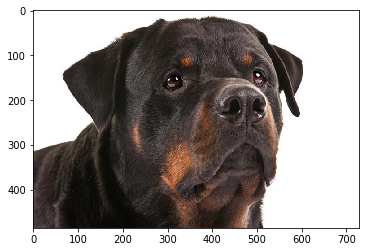

hello dog!
Your breed is ...
Beauceron


In [32]:
img_path='./images/Rottweiler.jpg'
run_app(img_path)

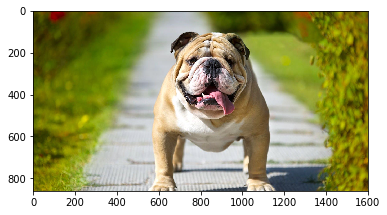

hello dog!
Your breed is ...
Bulldog


In [33]:
img_path='./images/Bulldog.jpg'
run_app(img_path)

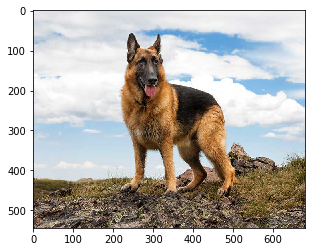

hello dog!
Your breed is ...
German shepherd dog


In [34]:
img_path='./images/german_sepherd.jpg'
run_app(img_path)

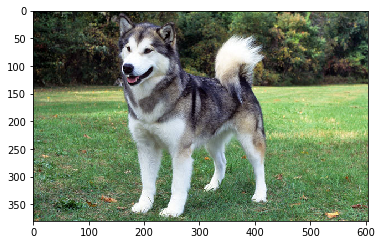

hello dog!
Your breed is ...
Alaskan malamute


In [35]:
img_path='./images/Alaskan_Malamute.jpg'
run_app(img_path)

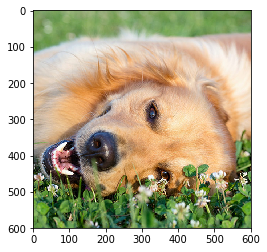

hello dog!
Your breed is ...
Golden retriever


In [36]:
img_path='./images/Golden_retriever.jpg'
run_app(img_path)

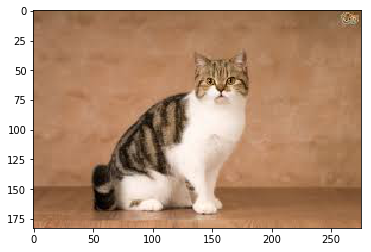

picture has neither dog nor human


In [37]:
img_path='./images/cat.jpg'
run_app(img_path)

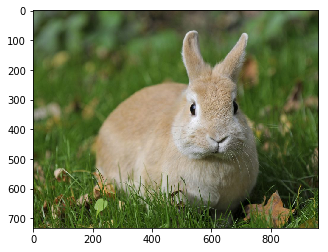

picture has neither dog nor human


In [38]:
img_path='./images/rabbit.jpg'
run_app(img_path)

# Repeat steps 4-6 using the VGG16 architecture

In [39]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer_2 = models.vgg16(pretrained=True)
# Freeze model weights
for param in model_transfer_2.parameters():
    param.requires_grad = False
 

model_transfer_2.classifier[6] = torch.nn.Linear(model_transfer_2.classifier[6].in_features, len(train_data.classes))

if use_cuda:
    model_transfer_2 = model_transfer_2.cuda()

In [40]:
model_transfer_2.classifier[6]

Linear(in_features=4096, out_features=133, bias=True)

In [41]:
model_transfer_2.classifier[6].in_features

4096

In [42]:
model_transfer_2.classifier[6].parameters()

<generator object Module.parameters at 0x7ffa74638518>

In [43]:
criterion_transfer = nn.CrossEntropyLoss()
lr = 1e-3
optimizer_transfer = optim.Adam(model_transfer_2.classifier[6].parameters(), lr)

Epoch: 1 	Training Loss: 1.230909 	Validation Loss: 0.522373
Validation loss decreased from (inf ---> 0.522373).	
Epoch: 2 	Training Loss: 0.390009 	Validation Loss: 0.398321
Validation loss decreased from (0.522373 ---> 0.398321).	
Epoch: 3 	Training Loss: 0.301292 	Validation Loss: 0.362842
Validation loss decreased from (0.398321 ---> 0.362842).	
Epoch: 4 	Training Loss: 0.254922 	Validation Loss: 0.387870
Epoch: 5 	Training Loss: 0.210875 	Validation Loss: 0.364694
Epoch: 6 	Training Loss: 0.197559 	Validation Loss: 0.400553
Epoch: 7 	Training Loss: 0.177072 	Validation Loss: 0.348931
Validation loss decreased from (0.362842 ---> 0.348931).	
Epoch: 8 	Training Loss: 0.157057 	Validation Loss: 0.531777
Epoch: 9 	Training Loss: 0.139655 	Validation Loss: 0.365146
Epoch: 10 	Training Loss: 0.133648 	Validation Loss: 0.423050
Epoch: 11 	Training Loss: 0.153420 	Validation Loss: 0.386686
Epoch: 12 	Training Loss: 0.134878 	Validation Loss: 0.402128
Epoch: 13 	Training Loss: 0.118592 	Va

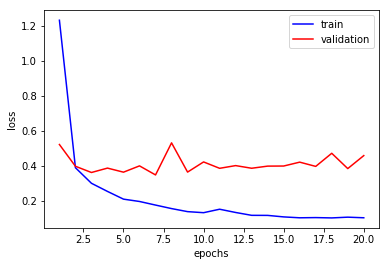

In [44]:
# train the model
n_epochs = 20
model_transfer_2 = train(n_epochs, loaders_transfer, model_transfer_2, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer_v2.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer_2.load_state_dict(torch.load('model_transfer_v2.pt'))

In [45]:
test(loaders_transfer, model_transfer_2, criterion_transfer, use_cuda)

Test Loss: 0.414587


Test Accuracy: 86% (723/836)


In [46]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    img_t = transform_img(img) # shape: (3,224,224)
    batch_t = torch.unsqueeze(img_t, 0) # shape: (1,3,224,224)
    batch_t = batch_t.cuda()
    
    model_transfer_2.eval()
    out = model_transfer_2(batch_t) # shape: (1,133)
    index = torch.argmax(out, dim=1).item()
    
    
    return class_names[index]

In [47]:
def model_predict(model, img_path):
    '''
    Use pre-trained model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to  model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    transform = transforms.Compose([     # defining a variable transform which is a combination of all the image transformations to be carried out on the input image     
            transforms.Resize(256),      # Resize the image to 256×256 pixels     
            transforms.CenterCrop(224),  # Crop the image to 224×224 pixels about the center   
            transforms.ToTensor(),       # Convert the image to PyTorch Tensor data type  
            transforms.Normalize(        # Normalize the image by setting its mean and standard deviation to the specified values          
            mean=[0.485, 0.456, 0.406],        
            std=[0.229, 0.224, 0.225])])

    img = Image.open(img_path)
    img_t = transform(img) # shape: (3,224,224)
    batch_t = torch.unsqueeze(img_t, 0) # shape: (1,3,224,224)
    #batch_t = batch_t.cuda()
    # put the model in eval mode
    model.eval() 
    out = model(batch_t) # shape: (1,1000)
    
    return torch.argmax(out, dim=1).item() # predicted class index

In [48]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

VGG16 = models.vgg16(pretrained=True)

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    img = cv2.imread(img_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()
        
    if dog_detector_model(VGG16, img_path)==True:        
        print('hello dog!')
        print('Your breed is ...')
        print(predict_breed_transfer(img_path))      
    elif face_detector(img_path)==True:
        print('hello human!')
        print('Your look like a ...')
        print(predict_breed_transfer(img_path))        
    else:
        print('picture has neither dog nor human')

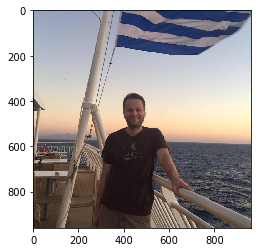

hello human!
Your look like a ...
Irish terrier


In [49]:
img_path='./images/myself.jpg'
run_app(img_path)

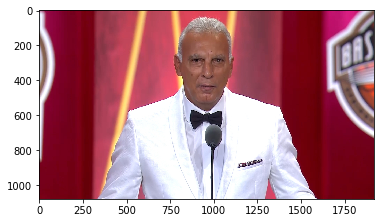

hello human!
Your look like a ...
Poodle


In [50]:
img_path='./images/Galis.jpg'
run_app(img_path)

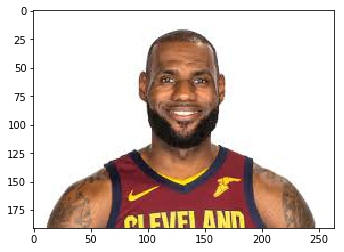

hello human!
Your look like a ...
Pharaoh hound


In [51]:
img_path='./images/Lebron.jpg'
run_app(img_path)

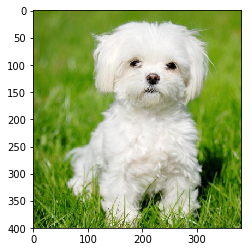

hello dog!
Your breed is ...
Maltese


In [52]:
img_path='./images/Maltese.jpg'
run_app(img_path)

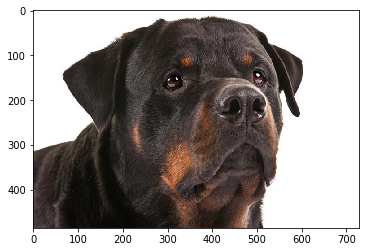

hello dog!
Your breed is ...
Beauceron


In [53]:
img_path='./images/Rottweiler.jpg'
run_app(img_path)

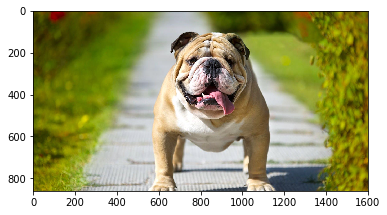

hello dog!
Your breed is ...
Bulldog


In [54]:
img_path='./images/Bulldog.jpg'
run_app(img_path)

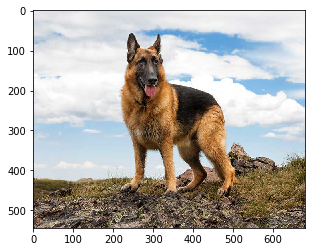

hello dog!
Your breed is ...
German shepherd dog


In [55]:
img_path='./images/german_sepherd.jpg'
run_app(img_path)

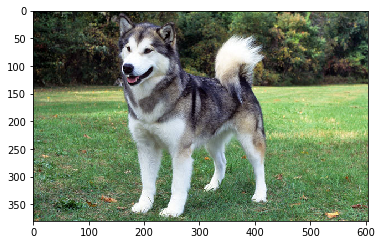

hello dog!
Your breed is ...
Alaskan malamute


In [56]:
img_path='./images/Alaskan_Malamute.jpg'
run_app(img_path)

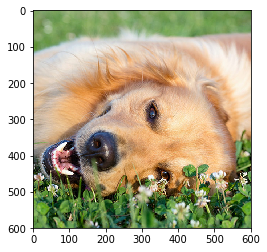

hello dog!
Your breed is ...
Golden retriever


In [57]:
img_path='./images/Golden_retriever.jpg'
run_app(img_path)

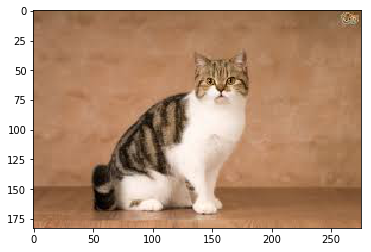

picture has neither dog nor human


In [58]:
img_path='./images/cat.jpg'
run_app(img_path)

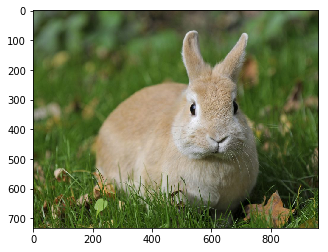

picture has neither dog nor human


In [59]:
img_path='./images/rabbit.jpg'
run_app(img_path)